<h1><center>Lyzenga's water column correction</center></h1>

<h2><center>Demo notebook</center></h2>

<h3><center><i>Teo Nguyen</i></center></h3>

This notebook is a tutorial example to show how to use the functions implemented in the `water_column_correction.py` file. 

These functions perform the Lyzenga's water column correction described in "Passive remote sensing techniques for mapping water depth and bottom features", 1978 (https://opg.optica.org/ao/abstract.cfm?uri=ao-17-3-379).

Here, we will compute the depth invariant images of a cropped Pleiades image of Maupiti island (French Polynesia). All the needed data can be found in the `data_for_test` folder.

### Importation of packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import water_column_correction

-------

You will have to compute the values of $L_{si}$ (as written in the paper), corresponding to the mean reflectance of a deep water zone on each band. The chosen zone must be deep enough to consider that the bottom type has no influence on the reflectance value. Here, we name these values `dw_B0*`, and previously computed them by taking an off-shore zone on my uncropped image.

In [2]:
dw_B00=0.17068201
dw_B01=0.10679955
dw_B02=0.056907434

### Data loading

Let's import the image and have a look at it.

In [3]:
B00=np.load('data_for_test/test_B00.npy')
B01=np.load('data_for_test/test_B01.npy')
B02=np.load('data_for_test/test_B02.npy')

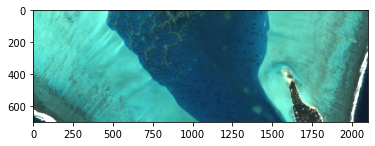

In [4]:
fig = plt.figure(figsize = (6,6))
plt.imshow(np.dstack((B02,B01,B00)))
plt.show()

Beautiful colors, isn't it?

Then we can load all the data used for the regression. This data must be a 1D array of the same size. I previously selected a zone on my image where I knew the bottom type is homogeneous, and where I have bathymetry values. 

In [5]:
B00_for_regression=np.load('data_for_test/B00_for_regression.npy')
B01_for_regression=np.load('data_for_test/B01_for_regression.npy')
B02_for_regression=np.load('data_for_test/B02_for_regression.npy')
bathy_for_regression=np.load('data_for_test/bathy_for_regression.npy')

### Water column correction

We then transform the raw array of pixels as the $X_i$ arrays, as defined in the paper, by the following equation:

$$ X_i = \ln(L_i-L_{si}) $$

Where $L_i$ is the reflectance over the band $i$, and $L_{si}$ is the mean reflectance over a deep water zone.

In [6]:
X00_for_regression=np.log(B00_for_regression-dw_B00)
X01_for_regression=np.log(B01_for_regression-dw_B01)
X02_for_regression=np.log(B02_for_regression-dw_B02)

We can then call the functions defined in the `water_column_correction.py` file.

In [7]:
# we get the slopes of the linear regression
b,_ = water_column_correction.linear_regression([X00_for_regression,X01_for_regression,X02_for_regression],
                                                bathy_for_regression)

# we compute the transformed bands Xi
list_X = water_column_correction.compute_Xi([B00,B01,B02], [dw_B00,dw_B01,dw_B02])

# we compute the coordinate system rotation parameters Aij
A = water_column_correction.Aij(b)

# we compute the depth invariant bands
di = water_column_correction.depth_invariant(A,list_X)

C:\Users\tnguyen001\Documents\GitHub\lyzenga1978\water_column_correction.py:35: RuntimeWarning: invalid value encountered in log
  list_Xi.append(np.log(band.reshape(-1)-dw))


*NB: some values are negative and cannot be computed by the logarithm, causing a RuntimeWarning. If you want to remove NaN values from your final data, you can replace them all by a small value (such as the min of the vector)*

We then reshape our final data. Indeed, `di0*` are a 1D vector, but we want to put them back as the same shape than the original input bands.

In [8]:
[di00, di01, di02]=water_column_correction.reshape_di(di, [B00,B01,B02])

We can finally plot the depth invariant image, and compare it with the raw image.

In [9]:
# This is to normalize the D.I. image to have a correct display with the 'imshow' function.

min00=np.min(di00[di00==di00])
max00=np.max(di00[di00==di00])
min01=np.min(di01[di01==di01])
min02=np.min(di02[di02==di02])
max01=np.max(di01[di01==di01])
max02=np.max(di02[di02==di02])

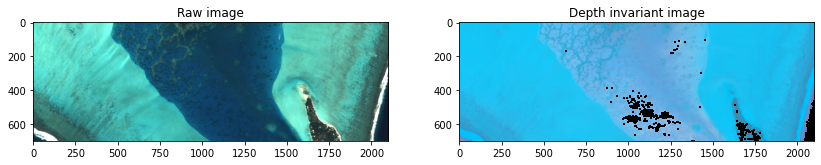

In [10]:
fig,ax = plt.subplots(ncols=2, figsize = (14,6))

ax[0].set_title('Raw image')
ax[0].imshow(np.dstack((B02,B01,B00)))

ax[1].set_title('Depth invariant image')
ax[1].imshow(np.dstack(((di02-min02)/(max02-min02),(di01-min01)/(max01-min01),(di00-min00)/(max00-min00))))

plt.show()

### Band per band analysis

We can further explore the effect of the water column correction by seeing the per-band result. By doing so, we can see that it works quite well on depth independant bands B00 and B01 (blue and green), but that the result on depth dependent red band B02 is obviously different.

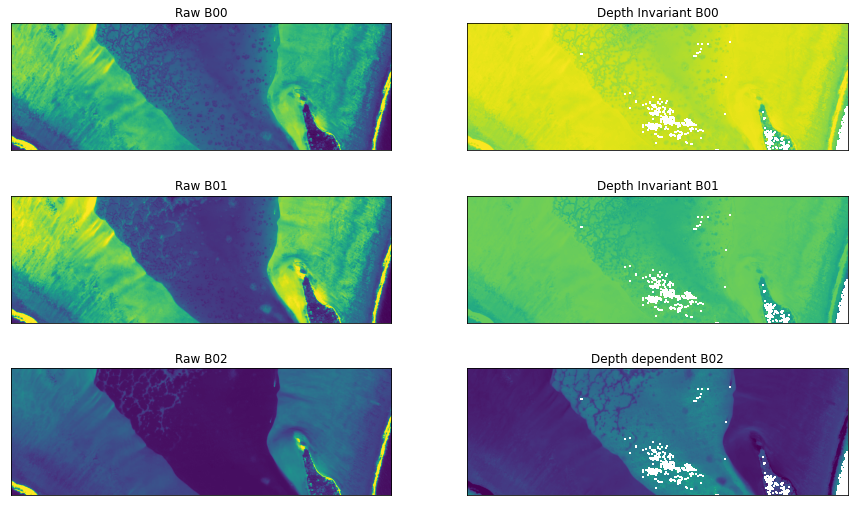

In [11]:
fig,ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,9))

ax[0,0].set_title('Raw B00')
ax[0,0].imshow(B00)

ax[0,1].set_title('Depth Invariant B00')
ax[0,1].imshow(di00)

ax[1,0].set_title('Raw B01')
ax[1,0].imshow(B01)

ax[1,1].set_title('Depth Invariant B01')
ax[1,1].imshow(di01)

ax[2,0].set_title('Raw B02')
ax[2,0].imshow(B02)

ax[2,1].set_title('Depth dependent B02')
ax[2,1].imshow(di02)

plt.setp(ax, xticks=[], yticks=[])

plt.show()

-------

### THE END

Thank you for having read this document. For any question, feel free to contact me: teo.nguyen@univ-pau.fr